In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
mpl.rcParams['text.usetex'] = False
# Import data
ec = 1.602e-19 #C 
hbar = 1.054e-34 #Js
kb = 1.380e-23 # J/K
me = 9.109e-31 #kg


In [4]:
# real data:
Txxp, Rxxp, Bxxp = np.loadtxt('0.1xxC1.6K.dat', skiprows=1, usecols=(0,3,13), unpack=True)
Txyp, Rxyp, Bxyp = np.loadtxt('0.1xyC2.0K.dat', skiprows=1, usecols=(0,3,13), unpack=True)

# Perform data corrections
Rxxp /= 1.3 # Aspect ratio correction

In [5]:
# Fitting linear resistivity
def linear_fit(x, m, c):
    return m * x + c

# Fitting the transverse resistivity
fit_tras, _ = curve_fit(linear_fit, Bxyp[Bxyp < 0.5], Rxyp[Bxyp < 0.5])
hall_coefficient = fit_tras[0] - fit_tras[1]

# Fitting the longitudinal resistivity
fit_long, _ = curve_fit(linear_fit, Bxxp[Bxxp < 0.5], Rxxp[Bxxp < 0.5])
r_0 = fit_long[1]

# Mobility/Density calculation
p = (1 / (hall_coefficient * ec)) * 1e-4
mu_H = (hall_coefficient / r_0) * 1e4
print(f'Carrier density: {p:.2E} [$cm^-2$]')
print(f'Mobility: {mu_H:.0f} [$cm^2$/Vs]')

# Effective mass calculation
meffCalc = 0.080*(1+0.056*(p/1e11))*me
print('calculated effective mass {:.4f} me'.format(meffCalc/me))

Carrier density: 6.18E+11 [$cm^-2$]
Mobility: 63500 [$cm^2$/Vs]
calculated effective mass 0.1077 me


In [6]:
# Definizione della funzione per l'intersezione delle due rette
def intersection_function(x):
    return np.polyval((fit_long - fit_tras), x)

# Trova l'intersezione delle due rette usando fsolve
x_intersection = fsolve(intersection_function, 0)

# Calcola il valore y corrispondente all'intersezione usando i coefficienti di fit_long_p
y_intersection = np.polyval(fit_long, x_intersection)

# Stampa i risultati
print(f'Punto di intersezione: x = {x_intersection[0]:.2f}, y = {y_intersection[0]:.2f}')
print('mu = 1/B = {:.0f} [$cm^2$/Vs], rho = {:.2f} Ohm/sq.'.format(1e4/x_intersection[0],y_intersection[0]))

Punto di intersezione: x = 0.16, y = 159.05
mu = 1/B = 63500 [$cm^2$/Vs], rho = 159.05 Ohm/sq.


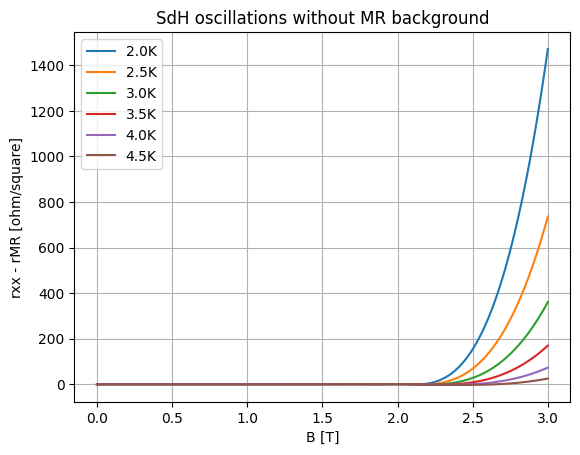

In [11]:
# Data processing for DFT
data_files = ['0.1xxC2.0K.dat', '0.1xxC2.5K.dat', '0.1xxC3.0K.dat', '0.1xxC3.5K.dat', '0.1xxC4.0K.dat', '0.1xxC4.5K.dat']
N = len(data_files)
D = np.zeros((1500, 7, N))
T = np.zeros(len(data_files))

# Funzione di interpolazione spline delle oscillazioni  
def spline_interp(x, y, new_x):
    unique_indices = np.unique(x, return_index=True)[1]
    x_unique = x[unique_indices]
    y_unique = y[unique_indices]
    sorted_indices = np.argsort(x_unique)
    x_sorted = x_unique[sorted_indices]
    y_sorted = y_unique[sorted_indices]
    spline = InterpolatedUnivariateSpline(x_sorted, y_sorted)
    return spline(new_x)
    
# Quadratic fitting for envelope calculation
def poly_fit(x, a, b, c):
    return a + b * x + c * x ** 2
    
# Loop per il caricamento e l'elaborazione dei dati
for i, data_file in enumerate(data_files):
    Txxp, Rxxp, Bxxp = np.loadtxt(data_file, skiprows=1, usecols=(0, 3, 13), unpack=True)
    B_vals = np.linspace(min(Bxxp), 3, 1500)
    Rxxp[1] /= 1.3
    T[i] = np.mean(Txxp)
    R_spline = spline_interp(Bxxp[Bxxp <= 3], Rxxp[Bxxp <= 3], B_vals)
    D[:, 0, i] = B_vals
    D[:, 1, i] = R_spline
    #print('Step %d done' % i)

# Loop per il fit polinomiale e calcolo degli envelope
for i in range(N):
    limitINF = 0.75
    lm = argrelextrema(D[:, 1, i], np.less)
    M_x = D[lm, 0, i][0]
    M_y = D[lm, 1, i][0]
    sup_env, _ = curve_fit(poly_fit, M_x, M_y)

    lm = argrelextrema(D[:, 1, i], np.greater)
    m_x = D[lm, 0, i][0]
    m_y = D[lm, 1, i][0]
    inf_env, _ = curve_fit(poly_fit, m_x, m_y)

    D[:, 2, i] = poly_fit(B_vals, *sup_env)
    D[:, 3, i] = poly_fit(B_vals, *inf_env)

for i in range(N):
    D[:, 4, i] = (D[:, 2, i] + D[:, 3, i]) / 2

for i in range(N):
    D[:, 5, i] = D[:, 1, i] - D[:, 4, i]

for i in range(N):
    D[:, 6, i] = D[:, 5, i] / y_intersection

# Plotting the results
names = ["2.0K", "2.5K", "3.0K", "3.5K", "4.0K", "4.5K"]
plt.figure()
for i in range(N):
    plt.plot(D[:, 0, i], D[:, 6, i], label=names[i])
plt.title('SdH oscillations without MR background')
plt.xlabel('B [T]')
plt.ylabel('rxx - rMR [ohm/square]')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Effective mass: 1.000


C:\userkeil\AppData\Local\Temp\ipykernel_9320\412327470.py:23: RuntimeWarning: divide by zero encountered in divide
  return a - np.log(np.sinh((2 * kb * m_eff * me * x * np.pi**2) / (ec * hbar * B0)))
C:\userkeil\AppData\Local\Temp\ipykernel_9320\412327470.py:26: OptimizeWarning: Covariance of the parameters could not be estimated
  par_fit, _ = curve_fit(effective_mass, T, Y)


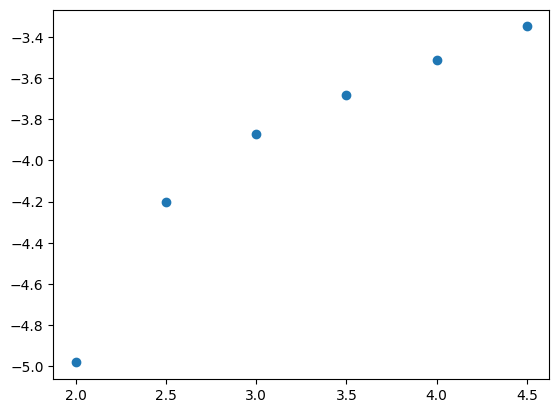

In [21]:
# Effective mass calculation
limitDWN = 2.20
limitUP = 2.57

peaks = []
B = []

for i in range(N):
    loc, _ = find_peaks(D[((D[:, 0, i] > limitDWN) & (D[:, 0, i] < limitUP)), 6, i])
    loc += np.argmax(D[:,0,i] > limitDWN)
    if loc.size == 0:
        B_peak = D[0, 0, i]
        peaks.append(D[0, 6, i])
        B.append(B_peak)
    else:
        B_peak = D[loc[0], 0, i]
        peaks.append(D[loc[0], 6, i])
        B.append(B_peak)
B0 = np.mean(B)

# Effective mass calculation
def effective_mass(x, a, m_eff):
    return a - np.log(np.sinh((2 * kb * m_eff * me * x * np.pi**2) / (ec * hbar * B0)))

Y = np.log(peaks / T)
par_fit, _ = curve_fit(effective_mass, T, Y)
m_eff = par_fit[1]
print(f'Effective mass: {m_eff:.3f}')

# Effective mass plot
# plt.plot(T,effective_mass(T,par_fit[0],par_fit[1]))
# plt.xlabel('Temperature')
# plt.ylabel('log (peaks / T)')
# plt.title('Effective Mass Plot')
plt.scatter(T,Y)

Effective mass: 0.108
Dingle factor alpha_D: 7.455
Transport relaxation time (tau_tr): 3.888E-12 s
Quantum relaxation time (tau_q): 5.216E-13 s


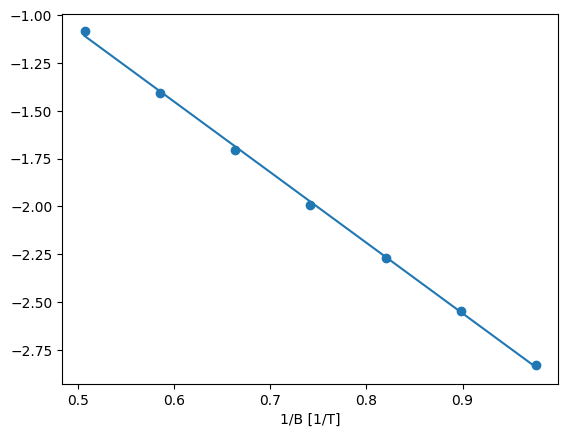

In [9]:
# Dingle ratio
mu = mu_H / 1e4  # m^2/Vs
limit = 1
T0 = T[0]
#mstar = m_eff * me
mstar = meffCalc
m_eff = mstar/me

loc, _ = find_peaks(D[(D[:, 0, 0] > limit), 6, 0], prominence=0.01)
loc += np.argmax(D[:, 0, 0] > limit)
Bval = D[loc,0,0]
peaks = D[loc,6,0]
ksi = (2 * np.pi ** 2 * kb * T0 * mstar) / (ec * hbar * Bval)
Z = np.log((np.sinh(ksi) / (4 * ksi)) * peaks)
X = 1 / Bval
line = np.polyfit(X, Z, 1)
Zi = np.polyval(line, X)

alpha_D = -(line[0] * mu) / np.pi
tau_tr = (mu * mstar) / ec
tau_q = tau_tr / alpha_D

plt.plot(X,Zi)
plt.scatter(X,Z)
plt.xlabel('1/B [1/T]')
# plt.ylabel('ln(A$frac{\xi}{4\xi})$')
print(f"Effective mass: {m_eff:.3f}")
print(f"Dingle factor alpha_D: {alpha_D:.3f}")
print(f"Transport relaxation time (tau_tr): {tau_tr:.3E} s")
print(f"Quantum relaxation time (tau_q): {tau_q:.3E} s")